In [1]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()

Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   created_at                  32092 non-null  datetime64[ns] 
 5   created_at_fe               21055 non-null  datetime64[ns] 
 6   amount                      32092 non-null  float64        
 7   fee                         21055 non-null  float64        
 8   stat_cr                     32092 non-null  object         
 9   stat_fe                     21055 non-null  object         
 10  transfer_type               32092 

In [ ]:
# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Calcular métricas mensuales para ver morosidad
monthly_data = df_jo.groupby('Mes_created_at').agg(
    # Calcular total de fees que no han sido cobradas
    total_non_paid_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['rejected', 'cancelled', 'confirmed'])].sum()),
    # Calcular total de fees que han sido fallidas (rejected y cancelled)
    total_failed_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['rejected', 'cancelled'])].sum()),
    
    # Calcular total de adelantos enviados, donde 'cash_request_received_date' no es nulo (ha sido recibido por el cliente)
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    ),
    
    # Calcular total de fees donde 'stat_fe' != 'cancelled'
    total_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] != 'cancelled'].sum()),
    # Calcular total de amount de cash_request adelantados donde 'status_cr' != 'money_back' y != 'active'
    total_cr_non_reimbur=('amount', lambda x: x[
        (df_jo.loc[x.index, 'stat_cr'] != 'money_back') & 
        (df_jo.loc[x.index, 'stat_cr'] != 'active') &
        (df_jo.loc[x.index, 'cash_request_received_date'].notnull())]
    .sum()
    )
).reset_index()

monthly_data

,Mes_created_at,total_non_paid_fees,total_failed_fees,total_adelantos,total_cr_non_reimbur
0,2019-11,0.0,0.0,0.0,0.0
1,2019-12,0.0,0.0,16349.0,2259.0
2,2020-01,0.0,0.0,10579.0,850.0
3,2020-02,0.0,0.0,10625.0,1000.0
4,2020-03,0.0,0.0,16200.0,350.0
5,2020-04,5.0,5.0,31333.0,1400.0
6,2020-05,765.0,765.0,57223.0,3300.0
7,2020-06,4040.0,4020.0,153973.0,24260.0
8,2020-07,5230.0,5185.0,184061.0,33230.0
9,2020-08,5865.0,5840.0,178451.0,28465.0


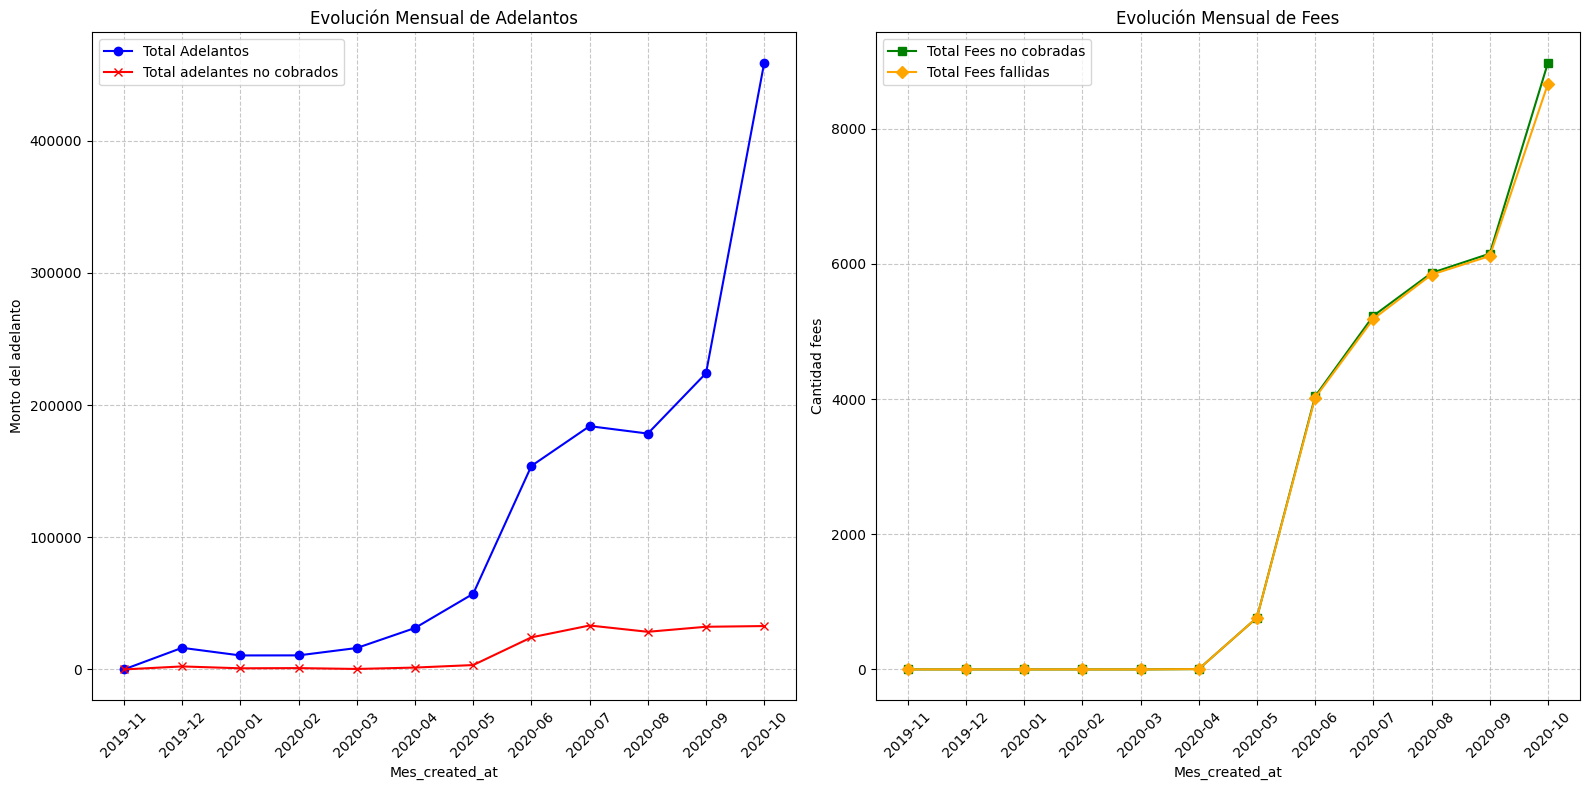

In [ ]:
# Crear la figura y los ejes para dos gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# Asegurar la conversión adecuada del eje x
monthly_data['Mes_created_at'] = monthly_data['Mes_created_at'].astype(str)

# Graficar adelantos en el primer gráfico
ax1.plot(
    monthly_data['Mes_created_at'], 
    monthly_data['total_adelantos'], 
    marker='o', 
    label='Total Adelantos', 
    color='blue'
)
ax1.plot(
    monthly_data['Mes_created_at'], 
    monthly_data['total_cr_non_reimbur'], 
    marker='x', 
    label='Total adelantes no cobrados', 
    color='red'
)


# Configurar etiquetas y título para el gráfico de adelantos
ax1.set_xlabel('Mes_created_at')
ax1.set_ylabel('Monto del adelanto')
ax1.set_title('Evolución Mensual de Adelantos')
ax1.legend()  # Mostrar la leyenda para las líneas
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Graficar fees en el segundo gráfico
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_non_paid_fees'], 
    marker='s', 
    label='Total Fees no cobradas', 
    color='green'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_failed_fees'], 
    marker='D', 
    label='Total Fees fallidas', 
    color='orange'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees'], 
    marker='s', 
    label='Total Fees', 
    color='green'


# Configurar etiquetas y título para el gráfico de fees
ax2.set_xlabel('Mes_created_at')
ax2.set_ylabel('Cantidad fees')
ax2.set_title('Evolución Mensual de Fees')
ax2.legend()  # Mostrar la leyenda para las líneas
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Ajustar el layout para que todo se vea bien
plt.tight_layout()

# Mostrar los gráficos
plt.show()


In [77]:
# Definir fecha de referencia desde donde calculamos morosidad (mes a partir de la cual no tenemos datos)
fecha_referencia = pd.Timestamp("2020-12-01")

# Calcular los días de deuda desde la fecha de referencia
df_debt['dias_deuda'] = (fecha_referencia - df_debt['cash_request_received_date']).dt.days


In [78]:
morosos_time_analysis = (
    df_debt.groupby(['user_id', 'Mes_created_at'], as_index=False)
    .agg(
        total_dias_deuda=('dias_deuda', 'mean'),  # Promedio de días que llevan debiendo dinero por mes y usuario
        total_dias_deuda_max=('dias_deuda', 'max')  # Máximo tiempo de deuda para casos extremos
    )
)
morosos_time_analysis

,user_id,Mes_created_at,total_dias_deuda,total_dias_deuda_max
0,47,2020-04,228.0,228
1,47,2020-05,197.0,197
2,47,2020-08,118.0,118
3,47,2020-09,69.0,69
4,47,2020-10,37.5,47
...,...,...,...,...
15778,99030337,2020-07,133.0,133
15779,99030337,2020-10,55.0,55
15780,99030367,2020-10,34.0,34
15781,99030404,2020-10,39.0,39


In [79]:
print(morosos_time_analysis['Mes_created_at'].dtype)

period[M]


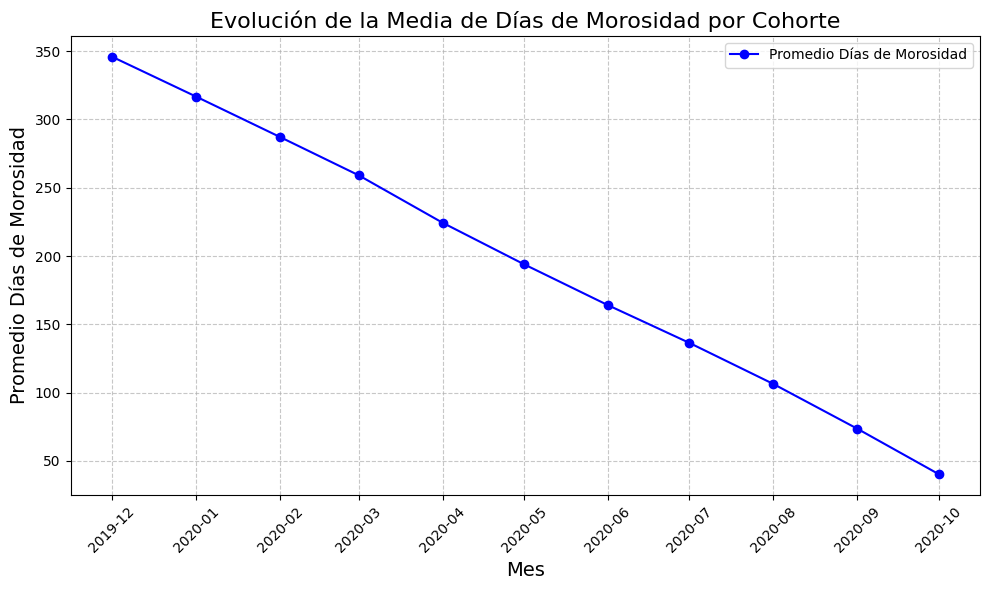

In [80]:
# Si 'Mes_created_at' es de tipo Period, lo convertimos a datetime
morosos_time_analysis['Mes_created_at'] = morosos_time_analysis['Mes_created_at'].dt.to_timestamp()

# Agrupar por 'Mes_created_at' para obtener la media de los días de deuda por mes
monthly_dias_deuda = morosos_time_analysis.groupby('Mes_created_at').agg(
    media_dias_deuda=('total_dias_deuda', 'mean')
).reset_index()

# Graficar la evolución de la media de días de deuda
plt.figure(figsize=(10, 6))
plt.plot(monthly_dias_deuda['Mes_created_at'], monthly_dias_deuda['media_dias_deuda'], marker='o', label='Promedio Días de Morosidad', color='blue')

# Personalizar el gráfico
plt.title('Evolución de la Media de Días de Morosidad por Cohorte', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Promedio Días de Morosidad', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [81]:
# Obtener valores únicos para cada columna de morosos_time_analysis
for column in morosos_time_analysis.columns:
    print(f"Valores únicos en la columna {column}:")
    print(morosos_time_analysis[column].unique())
    print(len(morosos_time_analysis[column].unique()))
    print()


Valores únicos en la columna user_id:
[      47       52       53 ... 99030367 99030404 99030445]
9323

Valores únicos en la columna Mes_created_at:
<DatetimeArray>
['2020-04-01 00:00:00', '2020-05-01 00:00:00', '2020-08-01 00:00:00',
 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2019-12-01 00:00:00',
 '2020-01-01 00:00:00', '2020-03-01 00:00:00', '2020-06-01 00:00:00',
 '2020-07-01 00:00:00', '2020-02-01 00:00:00']
Length: 11, dtype: datetime64[ns]
11

Valores únicos en la columna total_dias_deuda:
[228.         197.         118.          69.          37.5
 349.         112.          73.         343.         309.
 263.          38.         244.         344.         216.
 307.         181.         147.          68.         322.
 277.         226.         106.          77.          49.
 354.         319.          76.          43.         357.
 308.         115.          82.          42.         336.
 293.         258.         187.         160.         131.
 105.          80.          

In [94]:
# Agrupar por 'user_id' y sumar los 'total_dias_deuda'
total_dias_deuda_por_usuario = morosos_time_analysis.groupby(['user_id','Mes_created_at'])['total_dias_deuda'].sum().reset_index()

total_dias_deuda_por_usuario

,user_id,Mes_created_at,total_dias_deuda
0,47,2020-04-01,228.0
1,47,2020-05-01,197.0
2,47,2020-08-01,118.0
3,47,2020-09-01,69.0
4,47,2020-10-01,37.5
...,...,...,...
15778,99030337,2020-07-01,133.0
15779,99030337,2020-10-01,55.0
15780,99030367,2020-10-01,34.0
15781,99030404,2020-10-01,39.0
